In [5]:
import numpy as np
import pandas as pd
import torch
from sc_sharp import scSHARP
from test_model import test_model
import utilities
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import statistics

In [5]:
grid_results = pd.read_csv("grid_search_pbmc_output/combined.csv", header=None, index_col=0)
grid_results.columns = ["Total Accuracy", "Val Accuracy", "Test Accuracy", "Total SD", "Val SD", "Test SD", "Config", "Dropout", "Batch", "Neighbors"]
grid_results['GCN Layers'] = grid_results['Config'].apply(lambda x: x.split('_')[0])
grid_results['Final Embedding'] = grid_results['Config'].apply(lambda x: x.split('_')[1].split(".")[0])
grid_results['GCN Layers'] = pd.to_numeric(grid_results['GCN Layers'])
grid_results['Final Embedding'] = pd.to_numeric(grid_results['Final Embedding'])
grid_results.sort_values("Val Accuracy", ascending=False).head(10)

,Total Accuracy,Val Accuracy,Test Accuracy,Total SD,Val SD,Test SD,Config,Dropout,Batch,Neighbors,GCN Layers,Final Embedding
0,,,,,,,,,,,,
98,0.959807,0.941689,0.0,0.000524,0.002700,0.0,2_40.txt,0.0,50,5,2,40
16,0.959729,0.941287,0.0,0.001116,0.005750,0.0,2_25.txt,0.0,95,2,2,25
4,0.959625,0.940751,0.0,0.000812,0.004182,0.0,2_25.txt,0.0,35,2,2,25
161,0.959625,0.940751,0.0,0.000793,0.004085,0.0,2_60.txt,0.0,95,5,2,60
154,0.959443,0.939812,0.0,0.001093,0.005633,0.0,2_60.txt,0.0,65,2,2,60
157,0.959157,0.939812,0.0,0.001011,0.002230,0.0,2_60.txt,0.0,80,2,2,60
107,0.959339,0.939276,0.0,0.000736,0.003794,0.0,2_40.txt,0.0,95,5,2,40
139,0.959079,0.939142,0.0,0.000859,0.002543,0.0,2_15.txt,0.0,80,2,2,15
160,0.959287,0.939008,0.0,0.000565,0.002913,0.0,2_60.txt,0.0,95,2,2,60


<AxesSubplot:xlabel='Final Embedding', ylabel='Val Accuracy'>

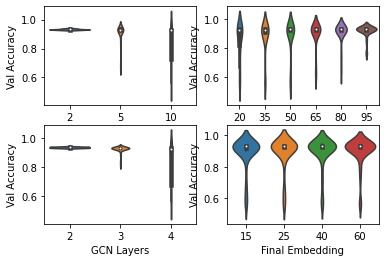

In [5]:
fig, axs = plt.subplots(2,2)
sns.violinplot(x=grid_results["Neighbors"], y=grid_results["Val Accuracy"], ax = axs[0][0])
sns.violinplot(x=grid_results["Batch"], y=grid_results["Val Accuracy"], ax = axs[0][1])
sns.violinplot(x=grid_results["GCN Layers"], y=grid_results["Val Accuracy"], ax = axs[1][0])
sns.violinplot(x=grid_results["Final Embedding"], y=grid_results["Val Accuracy"], ax = axs[1][1])

<AxesSubplot:xlabel='Batch', ylabel='Val Accuracy'>

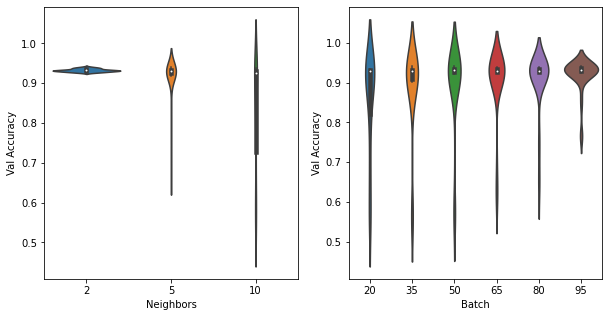

In [6]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.violinplot(x=grid_results["Neighbors"], y=grid_results["Val Accuracy"], ax = axs[0])
sns.violinplot(x=grid_results["Batch"], y=grid_results["Val Accuracy"], ax = axs[1])

<AxesSubplot:xlabel='Final Embedding', ylabel='Val Accuracy'>

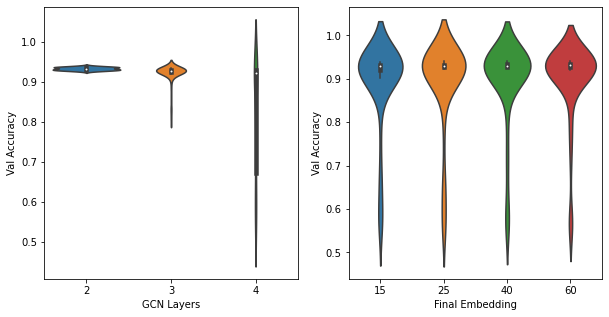

In [7]:
fig, axs = plt.subplots(1,2,figsize=(10, 5))
sns.violinplot(x=grid_results["GCN Layers"], y=grid_results["Val Accuracy"], ax = axs[0])
sns.violinplot(x=grid_results["Final Embedding"], y=grid_results["Val Accuracy"], ax = axs[1])

accuracy results generated this way:

srun --partition=gpu --mem=130g --time=500 python -u test_model.py
data_folders = ["/home/groups/ConradLab/daniel/sharp_data/pbmc_test/"]
    tools = ["sctype","scsorter","scina", "singler", "scpred"]
    votes_necessary = .51
    model_file = "configs/2_40.txt"
    neighbors = 5
    batch_size=50
    training_epochs=150
    random_inits = 5
    counts="counts.csv"
    meta="labels_cd4-8.csv"
    meta_col = 0
    df = test_model(data_folders, tools, votes_necessary, model_file, neighbors, batch_size, training_epochs, random_inits, counts=counts, meta=meta, meta_col=meta_col)
    df.to_csv("pbmc_test_results.csv")


In [6]:
results = pd.read_csv("pbmc_test_results.csv", index_col=0)
results

,data_name,method,total_accuracy,train_accuracy,test_accuracy,total_sd,train_sd,test_sd
0,pbmc_test,GCN,0.930186,0.937344,0.681247,0.000749,0.000207,0.019805
1,pbmc_test,Max Col.,0.921346,0.937523,0.358772,0.000000,0.000000,0.000000
2,pbmc_test,Confident Labels,NaN,0.937523,NaN,0.000000,0.000000,0.000000
3,pbmc_test,sctype,0.971137,0.973760,0.879944,0.000000,0.000000,0.000000
4,pbmc_test,scsorter,0.714819,0.716012,0.673336,0.000000,0.000000,0.000000
5,pbmc_test,scina,0.733328,0.753519,0.031177,0.000000,0.000000,0.000000
6,pbmc_test,singler,0.702813,0.719959,0.106561,0.000000,0.000000,0.000000
7,pbmc_test,scpred,0.744176,0.761535,0.140530,0.000000,0.000000,0.000000
8,pbmc_test,Tool Avg.,0.773255,0.784957,0.366310,0.111774,0.107426,0.383681


Text(0.5, 1.0, 'Total Accuracy by Method')

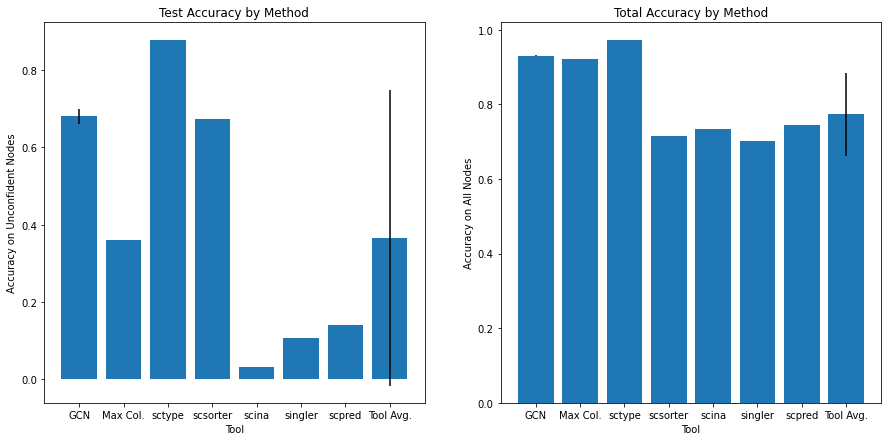

In [7]:
to_plot = results.loc[results['method']!="Confident Labels",:]
fig, ax = plt.subplots(1,2,figsize=(15, 7))
ax[0].bar(to_plot['method'],  to_plot['test_accuracy'], yerr= to_plot['test_sd'], align='center')
ax[0].set_xlabel("Tool")
ax[0].set_ylabel("Accuracy on Unconfident Nodes")
ax[0].set_title("Test Accuracy by Method")
ax[1].bar(to_plot['method'],  to_plot['total_accuracy'], yerr= to_plot['total_sd'], align='center')
ax[1].set_xlabel("Tool")
ax[1].set_ylabel("Accuracy on All Nodes")
ax[1].set_title("Total Accuracy by Method")

In [3]:
results = pd.read_csv("pbmc_test_results_marker_only.csv", index_col=0)
results

,data_name,method,total_accuracy,train_accuracy,test_accuracy,total_sd,train_sd,test_sd
0,pbmc_test,GCN,0.963864,0.964680,0.954001,0.000204,0.000139,0.002276
1,pbmc_test,Max Col.,0.958325,0.964778,0.880320,0.000000,0.000000,0.000000
2,pbmc_test,Confident Labels,NaN,0.964778,NaN,0.000000,0.000000,0.000000
3,pbmc_test,sctype,0.971137,0.973749,0.939564,0.000000,0.000000,0.000000
4,pbmc_test,scsorter,0.714819,0.770163,0.045795,0.000000,0.000000,0.000000
5,pbmc_test,scina,0.733328,0.793133,0.010385,0.000000,0.000000,0.000000
6,pbmc_test,Tool Avg.,0.806428,0.845682,0.331915,0.142942,0.111502,0.526538


Text(0.5, 1.0, 'Total Accuracy by Method')

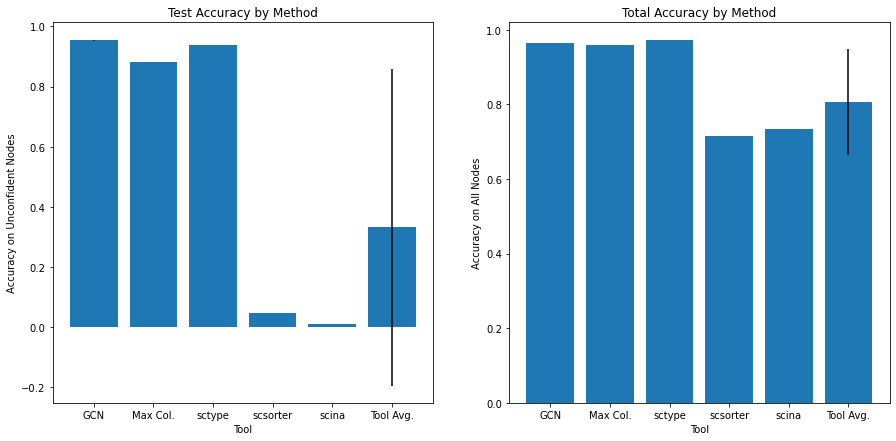

In [4]:
to_plot = results.loc[results['method']!="Confident Labels",:]
fig, ax = plt.subplots(1,2,figsize=(15, 7))
ax[0].bar(to_plot['method'],  to_plot['test_accuracy'], yerr= to_plot['test_sd'], align='center')
ax[0].set_xlabel("Tool")
ax[0].set_ylabel("Accuracy on Unconfident Nodes")
ax[0].set_title("Test Accuracy by Method")
ax[1].bar(to_plot['method'],  to_plot['total_accuracy'], yerr= to_plot['total_sd'], align='center')
ax[1].set_xlabel("Tool")
ax[1].set_ylabel("Accuracy on All Nodes")
ax[1].set_title("Total Accuracy by Method")

In [41]:
data_path = "/home/groups/ConradLab/daniel/sharp_data/pbmc_test/counts.csv"
tool_preds = "/home/groups/ConradLab/daniel/sharp_data/pbmc_test/preds.csv"
#tool_list = ["scina", "scsorter", "sctype", "singler", "scpred"]
tool_list = ["scina", "scsorter", "sctype"]
marker_path = "/home/groups/ConradLab/daniel/sharp_data/pbmc_test/markers.txt"
neighbors=5
config="configs/2_40.txt"
sharp = scSHARP(data_path, tool_preds, tool_list, marker_path, neighbors, config, ncells=15000)
#sharp.load_model("pbmc_test_trained_model_8_markers_only")
preds, train_nodes, test_nodes, keep_cells = sharp.run_prediction(training_epochs=200, thresh=0.51, batch_size=50, seed=8)

Loss in epoch 0 = 60.833565
Loss in epoch 10 = 3.289579
Loss in epoch 20 = 2.714696
Loss in epoch 30 = 2.586753
Loss in epoch 40 = 1.016582
Loss in epoch 50 = 1.111073
Loss in epoch 60 = 0.704361
Loss in epoch 70 = 2.521739
Loss in epoch 80 = 1.532788
Loss in epoch 90 = 0.627218
Loss in epoch 100 = 1.008951
Loss in epoch 110 = 0.037879
Loss in epoch 120 = 0.903825
Loss in epoch 130 = 1.738802
Loss in epoch 140 = 0.451237
Loss in epoch 150 = 0.866064
Loss in epoch 160 = 0.612220
Loss in epoch 170 = 2.263684
Loss in epoch 180 = 0.638509
Loss in epoch 190 = 0.950536


In [42]:
meta_path = "/home/groups/ConradLab/daniel/sharp_data/pbmc_test/labels_cd4-8.csv"
metadata = pd.read_csv(meta_path, index_col=0, nrows=15000)
real_y, names = pd.factorize(metadata.iloc[:,0], sort=True)
print(names)
real_y = real_y[keep_cells]
real_y.shape

Index(['b_cells', 'cd14_monocytes', 'cd4_t_cell', 'cd56_nk', 'cd8_t_cell'], dtype='object')


(14994,)

In [43]:
preds[train_nodes]

tensor([4, 3, 2,  ..., 4, 2, 4], device='cuda:0')

In [32]:
real_y[train_nodes]

array([4, 3, 2, ..., 4, 4, 2])

In [44]:
utilities.validation_metrics(torch.tensor(real_y), preds.cpu(), train_nodes, test_nodes)

(0.9634520411491394,
 array([[1748,    0,    0,    0,    0],
        [   5,  428,    4,    2,    0],
        [   6,   15, 7211,    2,  162],
        [   4,    1,    9, 1473,    6],
        [   3,    0,  319,   10, 3586]]),
 0.9644217491149902,
 array([[1748,    0,    0,    0,    0],
        [   5,  405,    4,    1,    0],
        [   6,   13, 6348,    2,  133],
        [   4,    1,    9, 1395,    5],
        [   3,    0,  302,    7, 3522]]),
 0.9509713053703308,
 array([[ 23,   0,   1,   0],
        [  2, 863,   0,  29],
        [  0,   0,  78,   1],
        [  0,  17,   3,  64]]))

In [45]:
int_df = sharp.run_interpretation()
int_df

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


,b_cells,cd14_monocytes,cd4_t_cell,cd56_nk,cd8_t_cell
AL627309.1,-0.167514,0.509929,-0.646798,0.452028,-0.435276
RP11-206L10.2,-0.454765,-0.033668,-0.549075,1.215869,0.080810
RP11-206L10.9,0.073451,0.072033,0.180408,-0.204979,-0.105984
LINC00115,-0.209631,-0.189203,-0.605565,0.152625,0.299449
FAM41C,0.064508,0.039802,-0.029637,-0.075548,-0.078613
...,...,...,...,...,...
AC011841.1,-0.137589,0.040664,-0.064072,0.200644,0.036142
AL354822.1,0.045645,-0.084721,-0.069796,-0.009400,0.026364
KIR2DL2,-0.211995,-0.135891,-0.241834,0.496279,0.167367
PNRC2.1,0.036464,-0.226860,-0.198929,0.481555,-0.150435


In [39]:
scale_int_df = pd.DataFrame(preprocessing.scale(int_df))
scale_int_df.columns = int_df.columns
scale_int_df.index = int_df.index
statistics.mean(scale_int_df.iloc[:,0])

/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/users/lewinsda/.conda/envs/daniel_thesis_2/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


7.707473410558882e-09

In [ ]:
keep_genes = scale_int_df.sort_values('b_cells', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values('cd14_monocytes', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd4_t_cell", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd56_nk", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd8_t_cell", ascending=False).head(4).index.tolist()
ax = sns.heatmap(scale_int_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

[Text(0.5, 14.09375, 'Cell Type')]

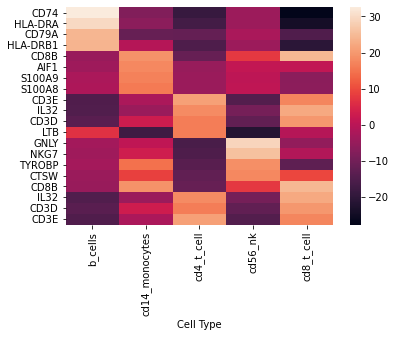

In [40]:
keep_genes = scale_int_df.sort_values('b_cells', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values('cd14_monocytes', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd4_t_cell", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd56_nk", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd8_t_cell", ascending=False).head(4).index.tolist()
ax = sns.heatmap(scale_int_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

In [8]:
int_df = pd.read_csv("pbmc_test_interpretation_markers_only_3_test.csv", index_col=0)

scale_int_df = pd.DataFrame(preprocessing.scale(int_df))
scale_int_df.columns = int_df.columns
scale_int_df.index = int_df.index
statistics.mean(scale_int_df.iloc[:,0])



-2.2508155923315823e-18

[Text(0.5, 14.09375, 'Cell Type')]

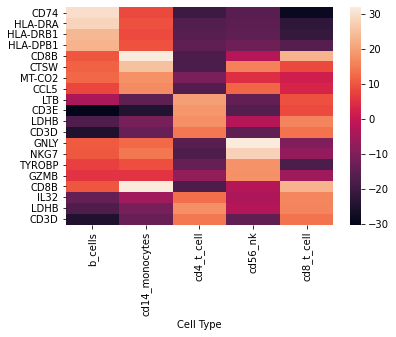

In [9]:
keep_genes = scale_int_df.sort_values('b_cells', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values('cd14_monocytes', ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd4_t_cell", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd56_nk", ascending=False).head(4).index.tolist()
keep_genes += scale_int_df.sort_values("cd8_t_cell", ascending=False).head(4).index.tolist()
ax = sns.heatmap(scale_int_df.loc[keep_genes,:])
ax.set(xlabel="Cell Type")

In [10]:
int_df.sort_values("cd8_t_cell", ascending=False).head(15)

,b_cells,cd14_monocytes,cd4_t_cell,cd56_nk,cd8_t_cell
CD8B,116.919040,358.929600,-147.206620,-18.925385,124.414215
IL32,-165.416030,-57.823532,111.105740,-27.692883,88.988260
LDHB,-205.930910,-126.854160,148.440220,-17.960610,87.202644
CD3D,-293.104000,-151.931690,120.630684,-123.482510,74.442250
NOSIP,-97.290630,-22.179750,75.798310,8.495882,62.313904
GIMAP7,-106.635840,-31.903704,84.297780,63.724937,61.641838
CD52,19.251904,-1.410357,60.302110,-75.358246,59.893510
TMEM66,-125.063416,-70.445830,73.557590,-1.597341,59.522910
NPM1,-45.055637,9.094661,35.506110,2.744280,58.391846
RGS10,-68.801735,21.322762,21.775013,0.262756,55.466507


In [12]:
(int_df['cd8_t_cell'] - int_df["cd4_t_cell"]).sort_values(ascending=False)

CD8B      195.379651
CTSW      136.848256
CCL5      113.952810
HCST       95.061545
CD8A       89.288700
             ...    
CORO1B    -58.203480
CD3E      -62.557420
FTH1      -67.799429
S100A4    -70.289234
LTB       -84.600580
Length: 17980, dtype: float64

In [13]:
int_df.sort_values("cd8_t_cell", ascending=False).loc["CD8A",:]

b_cells           10.709266
cd14_monocytes    92.354900
cd4_t_cell       -93.201584
cd56_nk           21.603033
cd8_t_cell        -3.912884
Name: CD8A, dtype: float64